In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from numpy import load

In [33]:
data = load('training_arrays/merged_training_arrays/all_organs_training_array.npy')

X = data[:,:-1]
y = data[:,-1]

# Find rows containing NaN values in X
nan_rows_X = np.isnan(X).any(axis=1)

# Drop rows with NaN values from X and y
X = X[~nan_rows_X]
y = y[~nan_rows_X]

min_max_scaler = MinMaxScaler()

X = min_max_scaler.fit_transform(X)


#scaler = StandardScaler()

#X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RegressionModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for i in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [38]:
batch_size = 512
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RegressionModel(input_size=5, hidden_size=256, output_size=1, num_layers=3, dropout=0.3)
model.to(device)  # Move the model to GPU if available

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2000

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item()
        val_loss /= len(val_loader)

    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


Epoch [1/2000] - Train Loss: 64.2554 - Val Loss: 23.6362
Epoch [2/2000] - Train Loss: 23.7552 - Val Loss: 20.1528
Epoch [3/2000] - Train Loss: 20.5354 - Val Loss: 17.6172
Epoch [4/2000] - Train Loss: 18.3943 - Val Loss: 15.6992
Epoch [5/2000] - Train Loss: 16.6086 - Val Loss: 14.0347
Epoch [6/2000] - Train Loss: 15.3157 - Val Loss: 13.6682
Epoch [7/2000] - Train Loss: 14.5249 - Val Loss: 12.4480
Epoch [8/2000] - Train Loss: 14.0739 - Val Loss: 12.1462
Epoch [9/2000] - Train Loss: 13.8283 - Val Loss: 11.8282
Epoch [10/2000] - Train Loss: 13.2564 - Val Loss: 12.0092
Epoch [11/2000] - Train Loss: 13.1464 - Val Loss: 11.3625
Epoch [12/2000] - Train Loss: 13.0871 - Val Loss: 11.2317
Epoch [13/2000] - Train Loss: 12.8458 - Val Loss: 11.2314
Epoch [14/2000] - Train Loss: 12.6354 - Val Loss: 11.1814
Epoch [15/2000] - Train Loss: 12.5125 - Val Loss: 10.8324
Epoch [16/2000] - Train Loss: 12.3181 - Val Loss: 10.9539
Epoch [17/2000] - Train Loss: 12.1518 - Val Loss: 10.7639
Epoch [18/2000] - Train

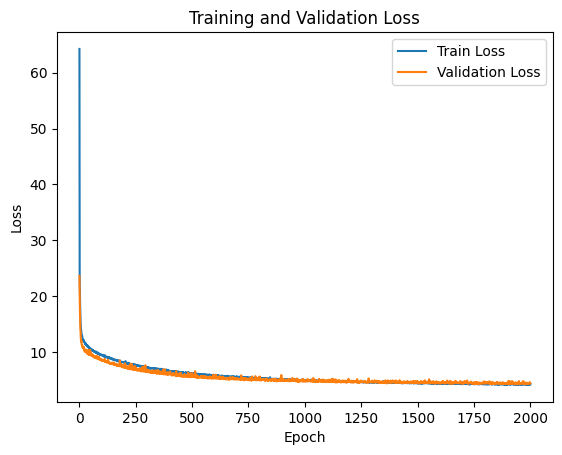

In [40]:
import matplotlib.pyplot as plt
# Move the losses to the CPU before plotting
#train_losses = [loss.cpu().detach().numpy() for loss in train_losses]
#val_losses = [loss.cpu().detach().numpy() for loss in val_losses]
# Plot the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [41]:
torch.save(model.state_dict(), 'models/all_organs_model.pth')

In [49]:
#load model
new_model = RegressionModel(input_size=5, hidden_size=256, output_size=1, num_layers=3, dropout=0.3)
new_model.load_state_dict(torch.load('models/all_organs_model.pth'))
new_model.to(device)


test_data = load('training_arrays/merged_training_arrays/aorta_test_array.npy')

X_test = test_data[:,:-1]
y_test = test_data[:,-1]

X_test = min_max_scaler.transform(X_test)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    new_model.eval()
    predictions = new_model(X_test).cpu().numpy()

predictions = predictions.reshape(-1)
print(f'Mean Percentage Error: {100*((np.mean(y_test) - np.mean(predictions))/np.mean(y_test)):.1f}%')

Mean Percentage Error: -3.2%


In [55]:
#evaluate patient by patient
import os

files = os.listdir('training_arrays/heart_myocardium')
diffs = []
for file in files[-31:]:
    print(file)
    data = load('training_arrays/heart_myocardium/' + file)
    X_test = data[:,:-1]
    y_test = data[:,-1]

    X_test = min_max_scaler.transform(X_test)

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        new_model.eval()
        predictions = new_model(X_test).cpu().numpy()

    diffs.append(abs(100*((np.mean(y_test) - np.mean(predictions))/np.mean(y_test))))

    print(f'Ground Truth dose (mGy): {np.mean(y_test):.1f}')
    print(f'Predicted dose (mGy): {np.mean(predictions):.1f}')
    print(f'Percent Error:  {100*((np.mean(y_test) - np.mean(predictions))/np.mean(y_test)):.1f}%')
    print('----------------------')
print(f'Mean Percentage Error: {np.nanmean(diffs):.1f}%')

kchan2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 12.7
Predicted dose (mGy): 12.3
Percent Error:  2.9%
----------------------
pitsikakis2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 12.2
Predicted dose (mGy): 12.2
Percent Error:  0.1%
----------------------
vacheva2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 10.3
Predicted dose (mGy): 12.4
Percent Error:  -20.3%
----------------------
pateraki2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 18.2
Predicted dose (mGy): 19.0
Percent Error:  -4.6%
----------------------
kandylaki2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 15.9
Predicted dose (mGy): 16.8
Percent Error:  -5.5%
----------------------
papoutsakisant2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 17.7
Predicted dose (mGy): 17.2
Percent Error:  2.8%
----------------------
georgieva2.5_heart_myocardium_training_array.npy
Ground Truth dose (mGy): 11.1
Predicted dose (mG